In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import cv2
import math
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import time
import pickle
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
import h5py
import keras_tuner as kt

## Model for separating texture or structure images

In [109]:
binary = "C:/Users/datre/OneDrive/Documents/Graduate School/Winter '21/Project 3/Binary/"

In [110]:
CATEGORIES = ["RSMAS", "StructureRSMAS"]

for category in CATEGORIES:
    path = os.path.join(binary, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))

In [111]:
size = 250
batch_size = 12

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    binary,
    validation_split = 0.2,
    subset = "training",
    seed = 123, 
    label_mode = "categorical", 
    image_size = (size, size), 
    batch_size = batch_size)

Found 1175 files belonging to 2 classes.
Using 940 files for training.


In [112]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    binary,
    validation_split = 0.2,
    subset = "validation",
    seed = 123, 
    label_mode = "categorical", 
    image_size = (size, size), 
    batch_size = batch_size)

Found 1175 files belonging to 2 classes.
Using 235 files for validation.


In [113]:
class_names = train_ds.class_names
print(class_names)

['RSMAS', 'StructureRSMAS']


In [114]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(250, 250, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation="relu"),

    tf.keras.layers.Dense(2, activation="sigmoid")])

In [115]:
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics="accuracy")

In [116]:
history = model.fit(train_ds,
    epochs=10,
    verbose=1,
    validation_data = val_ds)

Epoch 1/10
79/79 [==============================] - 57s 691ms/step - loss: 2.6698 - accuracy: 0.6277 - val_loss: 0.6621 - val_accuracy: 0.6809
Epoch 2/10
79/79 [==============================] - 58s 731ms/step - loss: 0.6418 - accuracy: 0.6883 - val_loss: 0.6049 - val_accuracy: 0.7064
Epoch 3/10
79/79 [==============================] - 57s 720ms/step - loss: 0.5287 - accuracy: 0.7915 - val_loss: 0.4580 - val_accuracy: 0.8638
Epoch 4/10
79/79 [==============================] - 58s 729ms/step - loss: 0.4149 - accuracy: 0.8787 - val_loss: 0.3881 - val_accuracy: 0.8553
Epoch 5/10
79/79 [==============================] - 56s 701ms/step - loss: 0.3197 - accuracy: 0.8979 - val_loss: 0.2561 - val_accuracy: 0.9191
Epoch 6/10
79/79 [==============================] - 56s 700ms/step - loss: 0.2456 - accuracy: 0.9245 - val_loss: 0.4842 - val_accuracy: 0.8511
Epoch 7/10
79/79 [==============================] - 58s 734ms/step - loss: 0.2482 - accuracy: 0.9181 - val_loss: 0.6037 - val_accuracy: 0.9191

In [117]:
model.evaluate(val_ds)

20/20 [==============================] - 5s 223ms/step - loss: 0.3797 - accuracy: 0.8596


[0.3796900510787964, 0.8595744967460632]

<Figure size 1500x1500 with 0 Axes>

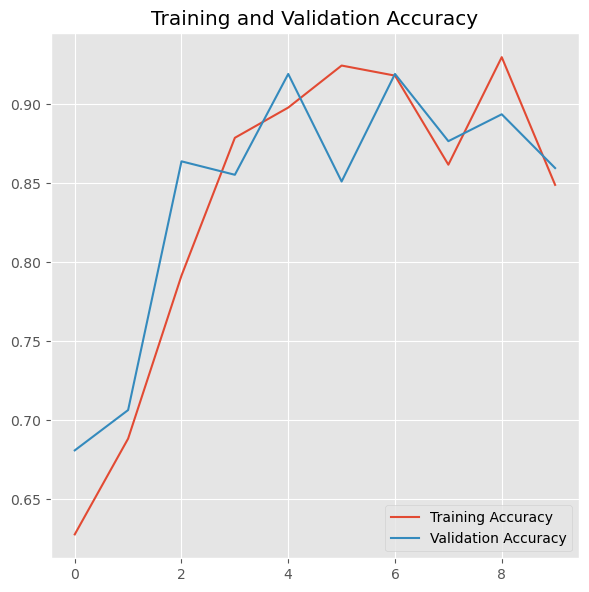

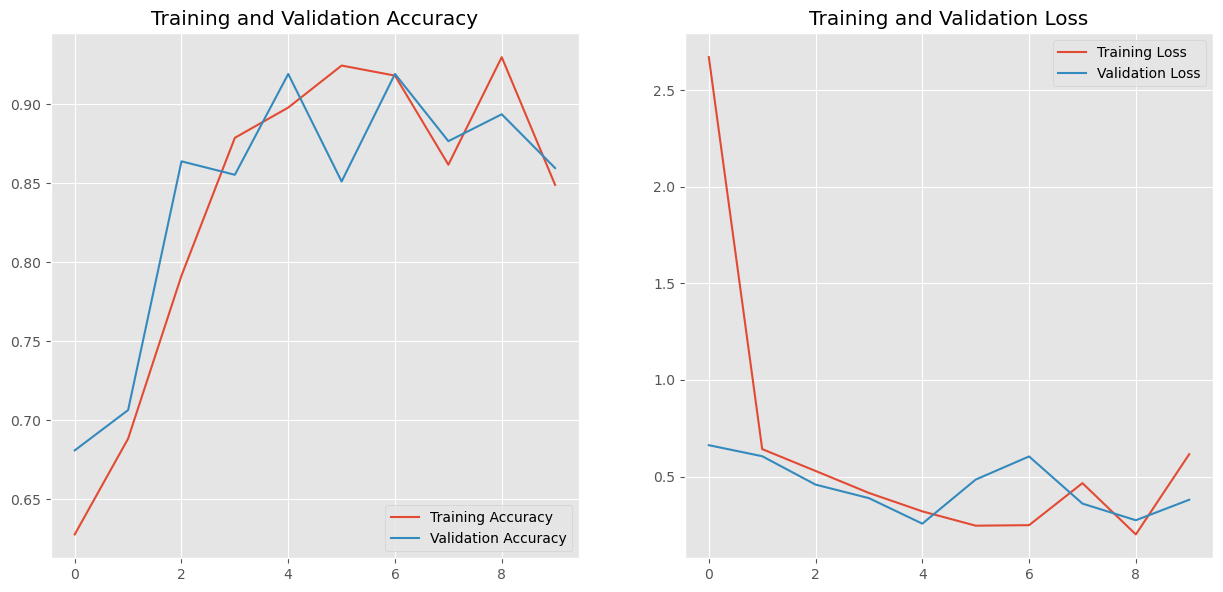

In [123]:
plt.style.use("ggplot")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
ax1 = plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')   

ax2 = plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model for determining structure species

In [72]:
structure = "C:/Users/datre/OneDrive/Documents/Graduate School/Winter '21/Project 3/Structure1/"

In [73]:
CATEGORIES = ["ACER", "APAL", "CNAT", "DANT", "MALC", "MCAV", "MMEA", "MONT", "PALY", "SPO", "SSID", "TUNI"]

In [74]:
s_dat = []

def make_data1():
    for category in CATEGORIES:
        path = os.path.join(structure, category)
        label = CATEGORIES.index(category)
        
        for img_name in os.listdir(path):
            image_path = os.path.join(path, img_name)
            image = cv2.imread(image_path)
            
            try: 
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224,224))
                
                image = np.array(image, dtype = np.float32)
                
                s_dat.append([image, label])
            except Exception as e:
                pass
    print(len(s_dat))
    pik = open("s_dat.pickle", "wb")
    pickle.dump(s_dat, pik)
    pik.close()

In [75]:
make_data1()

375


In [76]:
def load_data1():
    pick = open("s_dat.pickle", "rb")
    data2 = pickle.load(pick)
    pick.close()
    
    np.random.shuffle(s_dat)
    
    feature = []
    labels = []
    
    for img, label in s_dat:
        feature.append(img)
        labels.append(label)
        
    feature = np.array(feature, dtype = np.float32)
    labels = np.array(labels)
    feature = feature/255.0
    
    return [feature, labels]

In [77]:
(feature, labels) = load_data1()
X_train1, X_val1, y_train1, y_val1 = train_test_split(feature, labels, test_size = 0.2)

In [46]:
def model_builder(hp):
    model = keras.Sequential()
    hp_filt1 = hp.Int('filt1', min_value=32, max_value=128, step=32)
    model.add(keras.layers.Conv2D(filters = hp_filt1, kernel_size = (3,3), padding = "Same", activation = "relu", input_shape = (224, 224, 3)))
    model.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
        
    hp_filt2 = hp.Int('filt2', min_value=32, max_value=128, step=32)
    model.add(keras.layers.Conv2D(filters = hp_filt2, kernel_size = (3,3), padding = "Same", activation = "relu"))
    model.add(keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
    
    model.add(keras.layers.Flatten())
        
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    hp_drop = hp.Choice('drop', values = [0.5, 0.6, 0.7, 0.8, 0.9])
    model.add(keras.layers.Dropout(hp_drop))
    model.add(keras.layers.Dense(12, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
    return model

In [50]:
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_accuracy', # objective to optimize
max_epochs=10,
factor=3, # factor which you have seen above 
directory="C:/Users/datre/OneDrive/Documents/Graduate School/Winter '21/Project 3/", # directory to save logs 
project_name='structure model3')

In [51]:
tuner.search_space_summary() 

Search space summary
Default search space size: 5
filt1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
filt2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
drop (Choice)
{'default': 0.5, 'conditions': [], 'values': [0.5, 0.6, 0.7, 0.8, 0.9], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [54]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(feature, labels, epochs=10, validation_split=0.2, callbacks=[stop_early])


Search: Running Trial #32

Hyperparameter    |Value             |Best Value So Far 
filt1             |32                |32                
filt2             |64                |64                
units             |64                |416               
drop              |0.5               |0.5               
learning_rate     |0.01              |0.001             
tuner/epochs      |4                 |10                
tuner/initial_e...|0                 |4                 
tuner/bracket     |1                 |1                 
tuner/round       |0                 |1                 

Epoch 1/4
 3/10 [========>.....................] - ETA: 12s - loss: 105.7565 - accuracy: 0.0625

KeyboardInterrupt: 

In [78]:
input_layer = tf.keras.layers.Input([224,224,3])

conv1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = "Same", activation = "relu")(input_layer)
pool1 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv1)

conv2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (5,5), padding = "Same", activation = "relu")(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2))(conv2)

dpo1 = tf.keras.layers.Dropout(0.2)(pool2)
flt1 = tf.keras.layers.Flatten()(dpo1)
dn1 = tf.keras.layers.Dense(416, activation = "relu")(flt1)

out = tf.keras.layers.Dense(12, activation = "softmax")(dn1)

model = tf.keras.Model(input_layer, out)
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001), loss = keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(X_train1, y_train1, batch_size = 12, epochs = 8, validation_data = (X_val1, y_val1))

Epoch 1/8
25/25 [==============================] - 64s 2s/step - loss: 3.4944 - accuracy: 0.1067 - val_loss: 2.4777 - val_accuracy: 0.0667
Epoch 2/8
25/25 [==============================] - 54s 2s/step - loss: 2.4570 - accuracy: 0.1700 - val_loss: 2.4507 - val_accuracy: 0.1333
Epoch 3/8
25/25 [==============================] - 55s 2s/step - loss: 2.1507 - accuracy: 0.3533 - val_loss: 2.3871 - val_accuracy: 0.1867
Epoch 4/8
25/25 [==============================] - 56s 2s/step - loss: 1.4387 - accuracy: 0.5367 - val_loss: 2.5981 - val_accuracy: 0.2400
Epoch 5/8
25/25 [==============================] - 52s 2s/step - loss: 0.6226 - accuracy: 0.7933 - val_loss: 2.9222 - val_accuracy: 0.2533
Epoch 6/8
25/25 [==============================] - 53s 2s/step - loss: 0.2235 - accuracy: 0.9300 - val_loss: 4.3869 - val_accuracy: 0.2933
Epoch 7/8
25/25 [==============================] - 51s 2s/step - loss: 0.2029 - accuracy: 0.9500 - val_loss: 2.8681 - val_accuracy: 0.2133
Epoch 8/8
25/25 [==========

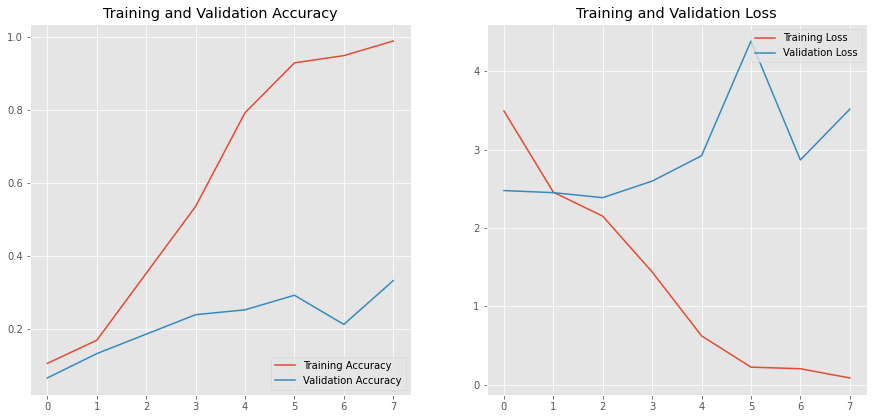

In [80]:
plt.style.use("ggplot")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model for determining texture species

In [198]:
texture = "C:/Users/datre/OneDrive/Documents/Graduate School/Winter '21/Project 3/Texture/"

In [199]:
CATEGORIES = ["ACER", "APAL", "CNAT", "DANT", "MALC", "MCAV", "MMEA", "MONT", "PALY", "SPO", "SSID", "TUNI"]

In [200]:
t_dat = []

def make_data2():
    for category in CATEGORIES:
        path = os.path.join(texture, category)
        label = CATEGORIES.index(category)
        
        for img_name in os.listdir(path):
            image_path = os.path.join(path, img_name)
            image = cv2.imread(image_path)
            
            try: 
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224,224))
                
                image = np.array(image, dtype = np.float32)
                
                t_dat.append([image, label])
            except Exception as e:
                pass
    print(len(t_dat))
    pik = open("t_dat.pickle", "wb")
    pickle.dump(t_dat, pik)
    pik.close()

In [201]:
make_data2()

263


In [202]:
def load_data2():
    pick = open("t_dat.pickle", "rb")
    data2 = pickle.load(pick)
    pick.close()
    
    np.random.shuffle(t_dat)
    
    feature = []
    labels = []
    
    for img, label in t_dat:
        feature.append(img)
        labels.append(label)
        
    feature = np.array(feature, dtype = np.float32)
    labels = np.array(labels)
    feature = feature/255.0
    
    return [feature, labels]

In [203]:
(feature, labels) = load_data2()
X_train2, X_val2, y_train2, y_val2 = train_test_split(feature, labels, test_size = 0.2)

In [204]:
input_layer = tf.keras.layers.Input([224,224,3])

conv1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5), padding = "Same", activation = "relu")(input_layer)
pool1 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv1)

conv2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu")(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2))(conv2)

conv3 = tf.keras.layers.Conv2D(filters = 96, kernel_size = (3,3), padding = "Same", activation = "relu")(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2))(conv3)

dpo1 = tf.keras.layers.Dropout(0.8)(pool3)
flt1 = tf.keras.layers.Flatten()(dpo1)
dn1 = tf.keras.layers.Dense(512, activation = "relu")(flt1)

out = tf.keras.layers.Dense(12, activation = "softmax")(dn1)

model3 = tf.keras.Model(input_layer, out)
model3.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
history = model.fit(X_train2, y_train2, batch_size = 10, epochs = 10, validation_data = (X_val2, y_val2))

Epoch 1/10
21/21 [==============================] - 27s 1s/step - loss: 2.5749 - accuracy: 0.1714 - val_loss: 2.0894 - val_accuracy: 0.1887
Epoch 2/10
21/21 [==============================] - 23s 1s/step - loss: 2.1132 - accuracy: 0.2524 - val_loss: 1.9454 - val_accuracy: 0.3585
Epoch 3/10
21/21 [==============================] - 23s 1s/step - loss: 1.8064 - accuracy: 0.3571 - val_loss: 1.5786 - val_accuracy: 0.4528
Epoch 4/10
21/21 [==============================] - 23s 1s/step - loss: 1.4523 - accuracy: 0.5429 - val_loss: 1.3475 - val_accuracy: 0.5472
Epoch 5/10
21/21 [==============================] - 23s 1s/step - loss: 1.0869 - accuracy: 0.6381 - val_loss: 1.1472 - val_accuracy: 0.5660
Epoch 6/10
21/21 [==============================] - 24s 1s/step - loss: 0.9761 - accuracy: 0.6810 - val_loss: 0.7433 - val_accuracy: 0.7358
Epoch 7/10
21/21 [==============================] - 22s 1s/step - loss: 0.5989 - accuracy: 0.7905 - val_loss: 1.4186 - val_accuracy: 0.6226
Epoch 8/10
21/21 [==

In [205]:
model3.evaluate(X_val2, y_val2, verbose = 1)

2/2 [==============================] - 1s 518ms/step - loss: 0.9427 - accuracy: 0.7547


[0.9427011013031006, 0.7547169923782349]

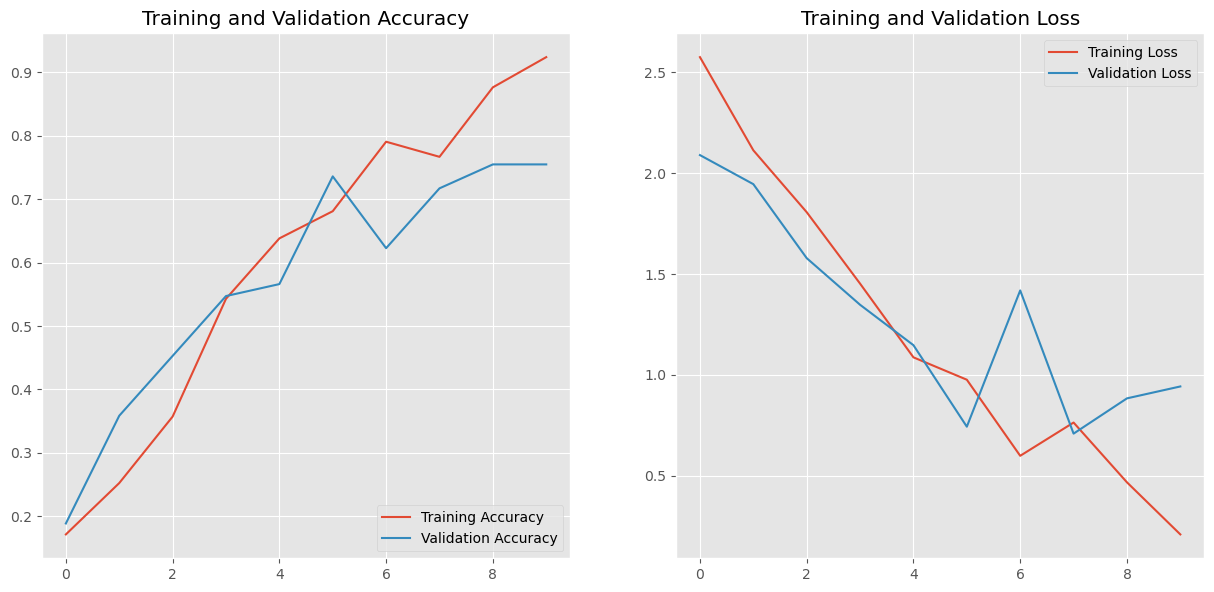

In [206]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()